In [9]:
import torch
import torch.nn as nn

import numpy as np
import copy
import random

import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sine_data_generator
import models.encoder
import models.decoder

from sine_data_generator import SineDataGenerator
from models.encoder import IOPairSetEncoder
from models.decoder import Decoder
from models.lpn import LPN
from models.utils import relu_seq, ReluNet, make_leave_one_out

### Data

In [38]:
data_gen = SineDataGenerator(10, 16)

inputs_np, outputs_np, amp_np, phase_np = data = data_gen.generate()
xs, outputs_pred, amp, phase = [torch.Tensor(arr) for arr in data]

In [39]:
xs.shape, outputs_pred.shape, amp.shape, phase.shape

(torch.Size([16, 10, 1]),
 torch.Size([16, 10, 1]),
 torch.Size([16]),
 torch.Size([16]))

### Modules

#### Encoder

In [40]:
io_pairs = torch.cat([xs, outputs_pred], dim=-1)  # (batch_size, N, 2)
io_pairs.shape

torch.Size([16, 10, 2])

In [41]:
set_encoder = IOPairSetEncoder()
z_mu, z_logvar = set_encoder(io_pairs)
z_sample = z_mu
z_sample.shape  # (batch_size, output_dim)

torch.Size([16, 3])

In [42]:
set_encoder

IOPairSetEncoder(
  (phi): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (rho_0): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (rho_1): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=3, bias=True)
    )
  )
  (rho_2): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=3, bias=True)
    )
  )
)

#### Decoder

In [43]:
z_sample.shape, xs.shape

(torch.Size([16, 3]), torch.Size([16, 10, 1]))

In [44]:
input_0 = xs[:, 0, :]  # (batch_size, d_input)
input_0.shape

torch.Size([16, 1])

In [45]:
z_expanded = z_sample.unsqueeze(1).expand(-1, xs.size(1), -1)
z_inputs = torch.cat([z_expanded, xs], axis=-1)
z_inputs.shape

torch.Size([16, 10, 4])

In [46]:
decoder = Decoder()
decoder

Decoder(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [47]:
decoder(z_inputs).shape

torch.Size([16, 10, 1])

### Utils

In [48]:
def make_leave_one_out(array: torch.Tensor, axis: int) -> torch.Tensor:
    """
    Args:
        array: Tensor of shape (*B, N, *H).
        axis: The axis where N appears.

    Returns:
        Tensor of shape (*B, N, N-1, *H).
    """
    axis = axis % array.ndim
    n = array.size(axis)
    output = []

    for i in range(n):
        array_before = array.narrow(axis, 0, i)
        array_after = array.narrow(axis, i + 1, n - i - 1)
        sliced = torch.cat([array_before, array_after], dim=axis)
        output.append(sliced)

    output = torch.stack(output, dim=axis)
    return output

In [49]:
# Create a random tensor
random_array = torch.randn(4, 5, 6)  # Example shape (4, 5, 6)

# Apply the make_leave_one_out function
leave_one_out_result = make_leave_one_out(random_array, axis=1)

# Print the shapes to verify
print("Original shape:", random_array.shape)
print("Leave-one-out shape:", leave_one_out_result.shape)

Original shape: torch.Size([4, 5, 6])
Leave-one-out shape: torch.Size([4, 5, 4, 6])


In [50]:
random_array[0, :, :]

tensor([[-1.2445, -1.9047,  1.0075, -2.0299, -1.2347, -0.5570],
        [-0.7741,  0.6716,  0.8801,  0.0924,  2.2735,  0.2846],
        [ 0.5475,  1.0939,  1.1174,  0.0086,  0.0124, -1.6234],
        [-1.9776,  0.1147,  0.1172, -1.2986,  0.9240,  0.1987],
        [-2.7388, -0.3303,  0.2065, -0.3761, -0.0858,  1.5565]])

In [51]:
leave_one_out_result[0, 0, :, :]

tensor([[-0.7741,  0.6716,  0.8801,  0.0924,  2.2735,  0.2846],
        [ 0.5475,  1.0939,  1.1174,  0.0086,  0.0124, -1.6234],
        [-1.9776,  0.1147,  0.1172, -1.2986,  0.9240,  0.1987],
        [-2.7388, -0.3303,  0.2065, -0.3761, -0.0858,  1.5565]])

### LPN

In [52]:
# z: (H,)
# inputs: (B, 1)
B = 3  # Batch size
N = 5
H = 7  # Latent dimension

# Generate random z and inputs
z_init = torch.randn(H)  # Random latent variables of shape (B, H)
xs = torch.randn(B, 1)  # Random inputs of shape (B, 1)

# z_expanded = z.unsqueeze(0).expand(B, -1)
z_init.unsqueeze(0).expand(B, -1).shape

torch.Size([3, 7])

In [53]:
torch.manual_seed(0)
ys_1 = torch.randn(B, N, N-1, 1)
ys_2 = torch.randn(B, N, N-1, 1)
mse = nn.functional.mse_loss(ys_1, ys_2, reduction='none') # (B, N, 1)
mse.sum(dim=-2).shape

torch.Size([3, 5, 1])

In [54]:
z_init = torch.randn(B, N, H)
z_init.unsqueeze(2).expand(-1, -1, N-1, -1).shape

torch.Size([3, 5, 4, 7])

### Training

In [ ]:
import wandb
wandb.init(settings=wandb.Settings(save_code=False))
wandb.finish()
wandb.init(project="lpn4sine_cf_maml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_metaiter = 70_001
n_samples_per_task = 20
batch_size = 25

# number of inner gradient steps (in training)
numstep = 1

data_gen = SineDataGenerator(n_samples_per_task, batch_size)

# alpha = 4e-4

# Init encoder-decoder
# encoder = IOPairSetEncoder(phi=ReluNet(2, 32, 32),
#                            rho_0=ReluNet(32, 32, 16),
#                            rho_1=ReluNet(16, 8, d_latent))

# decoder = Decoder(d_input=1, d_latent=d_latent, ds_hidden=[32, 32], d_output=1)
d_latent = 4

encoder = IOPairSetEncoder(phi=ReluNet(2, 16, 32),
                           rho_0=ReluNet(32, 16, 16),
                           rho_1=ReluNet(16, 8, d_latent))

decoder = Decoder(d_input=1, d_latent=d_latent, ds_hidden=[16, 16, 16], d_output=1)

lpn = LPN(d_input=1,
          d_output=1,
          d_latent=d_latent,
          encoder=encoder,
          decoder=decoder).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print("Total parameters:", count_parameters(lpn))

optimizer = torch.optim.AdamW(lpn.parameters(), lr=1e-3)

losses = []

for i in range(n_metaiter):
    lpn.train()
    optimizer.zero_grad()

    xs, ys, amp, phase = data_gen.generate()
    io_pairs = torch.cat([xs, ys], dim=-1).to(device)  # (B, N, 2)

    _, loss = lpn(io_pairs, K=numstep, debug=(i==0))

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        wandb.log({"loss": loss.item()})
        losses.append(loss.item())
    if i % 1000 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")


wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Total parameters: 2393
torch.sum(mse).item()=33225.72265625
Step 0, Loss: 1.7485
Step 1000, Loss: 1.5282
Step 2000, Loss: 0.2261
Step 3000, Loss: 0.2081
Step 4000, Loss: 0.1834
Step 5000, Loss: 0.0827
Step 6000, Loss: 0.1061
Step 7000, Loss: 0.1082
Step 8000, Loss: 0.0740
Step 9000, Loss: 0.0720
Step 10000, Loss: 0.0521
Step 11000, Loss: 0.0607
Step 12000, Loss: 0.0600
Step 13000, Loss: 0.0684
Step 14000, Loss: 0.0566
Step 15000, Loss: 0.0478
Step 16000, Loss: 0.0530
Step 17000, Loss: 0.0599
Step 18000, Loss: 0.0623
Step 19000, Loss: 0.0622
Step 20000, Loss: 0.0596
Step 21000, Loss: 0.0873
Step 22000, Loss: 0.0395
Step 23000, Loss: 0.0646
Step 24000, Loss: 0.0277
Step 25000, Loss: 0.0418
Step 26000, Loss: 0.0606
Step 27000, Loss: 0.0634
Step 28000, Loss: 0.0395
Step 29000, Loss: 0.0570
Step 30000, Loss: 0.0505
Step 31000, Loss: 0.0361
Step 32000, Loss: 0.0520
Step 33000, Loss: 0.0380
Step 34000, Loss: 0.0666
Step 35000, Loss: 0.0370
Step 36000, Loss: 0.0391
Step 37000, Loss: 0.0485
Ste

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Step 70000, Loss: 0.0395


In [7]:
wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


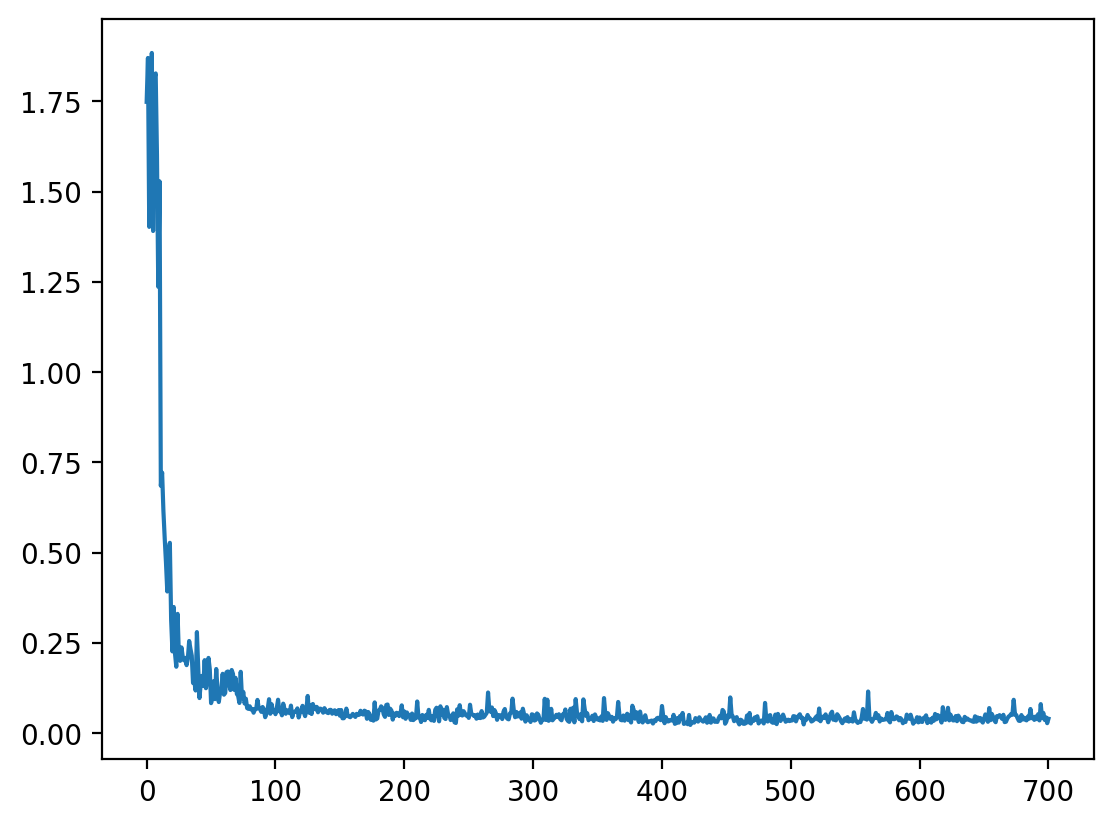

In [37]:
plt.plot(losses)
plt.show()

#### Testing: cf MAML

In [42]:
n_test_points = 600
test_batch_size = 1
n_test_samples_per_task = 20
n_support_samples_per_task = 10
n_query_samples_per_task = n_test_samples_per_task - n_support_samples_per_task

test_numstep = 100

data_gen = SineDataGenerator(n_test_samples_per_task, test_batch_size)

np.random.seed(1)
random.seed(1)

metaeval_losses = np.full((n_test_points, test_numstep + 1), np.nan)

for i_test_task in range(n_test_points):
    test_xs, test_ys, amp, phase = data_gen.generate()
    support_xs = test_xs[:, :n_support_samples_per_task, :]
    support_ys = test_ys[:, :n_support_samples_per_task, :]
    query_xs = test_xs[:, n_support_samples_per_task:, :]
    query_ys = test_ys[:, n_support_samples_per_task:, :]

    support_pairs = torch.cat([support_xs, support_ys], dim=-1).to(device)  # (B, N, 2)
    aux_t, loss_t = lpn(support_pairs, K=test_numstep, debug=True)

    y_pred = aux_t["ys_pred"].detach().cpu().numpy()
    z_mu = aux_t["z_mu"]
    z_logvar = aux_t["z_logvar"]
    # z_sample = aux_t["z_sample"].detach()
    # z_prime = aux_t["z_prime"].detach()
    z_traj = aux_t["z_traj"]

    z_sample = z_traj[0]
    z_prime = z_traj[-1]

    assert len(z_traj) == test_numstep + 1
    for i_step, z in enumerate(z_traj):
        z = z.mean(dim=1).squeeze(0)  # (d_latent,)
        assert z.shape == (d_latent,)

        # Evaluate MSE loss of z on the query set
        assert query_xs.shape == (test_batch_size, n_query_samples_per_task, 1)
        assert query_xs.squeeze(0).shape == (test_batch_size * n_query_samples_per_task, 1)
        query_ys_pred = lpn.decode(z, query_xs.squeeze(0).to(device))
        assert query_ys_pred.shape == (test_batch_size * n_query_samples_per_task, 1)
        mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')
        metaeval_losses[i_test_task, i_step] = mse.item()



torch.sum(mse).item()=47.96576690673828
torch.sum(mse).item()=11.877341270446777
torch.sum(mse).item()=5.780745983123779
torch.sum(mse).item()=3.890657901763916
torch.sum(mse).item()=2.9023122787475586
torch.sum(mse).item()=2.2568178176879883
torch.sum(mse).item()=1.7323238849639893
torch.sum(mse).item()=1.3321715593338013
torch.sum(mse).item()=1.0445590019226074
torch.sum(mse).item()=0.840416669845581
torch.sum(mse).item()=0.6911450624465942
torch.sum(mse).item()=0.5817697048187256
torch.sum(mse).item()=0.5007384419441223
torch.sum(mse).item()=0.4427874684333801
torch.sum(mse).item()=0.40087345242500305
torch.sum(mse).item()=0.3693748116493225
torch.sum(mse).item()=0.3466119170188904
torch.sum(mse).item()=0.3301088213920593
torch.sum(mse).item()=0.31797778606414795
torch.sum(mse).item()=0.3089092969894409
torch.sum(mse).item()=0.30222287774086
torch.sum(mse).item()=0.29726192355155945
torch.sum(mse).item()=0.2935953140258789
torch.sum(mse).item()=0.2908640503883362
torch.sum(mse).item

/tmp/ipykernel_39231/137366657.py:46: UserWarning: Using a target size (torch.Size([1, 10, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')


torch.sum(mse).item()=0.5106760263442993
torch.sum(mse).item()=0.5097667574882507
torch.sum(mse).item()=0.5088995099067688
torch.sum(mse).item()=0.5080916881561279
torch.sum(mse).item()=0.5073103904724121
torch.sum(mse).item()=0.5065435171127319
torch.sum(mse).item()=0.5057898759841919
torch.sum(mse).item()=0.5050466060638428
torch.sum(mse).item()=0.5043146014213562
torch.sum(mse).item()=0.5036274194717407
torch.sum(mse).item()=0.5029797554016113
torch.sum(mse).item()=0.5022168159484863
torch.sum(mse).item()=0.5002080202102661
torch.sum(mse).item()=0.4986482560634613
torch.sum(mse).item()=0.4973651170730591
torch.sum(mse).item()=0.4962261915206909
torch.sum(mse).item()=0.4952314496040344
torch.sum(mse).item()=0.4943152070045471
torch.sum(mse).item()=0.49344679713249207
torch.sum(mse).item()=0.49261021614074707
torch.sum(mse).item()=0.49179401993751526
torch.sum(mse).item()=0.4909954071044922
torch.sum(mse).item()=0.49023914337158203
torch.sum(mse).item()=0.48924654722213745
torch.sum(m

In [39]:
for z in z_traj:
    print(z.shape)

torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])
torch.Size([1, 10, 4])


/tmp/ipykernel_39231/4209139884.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


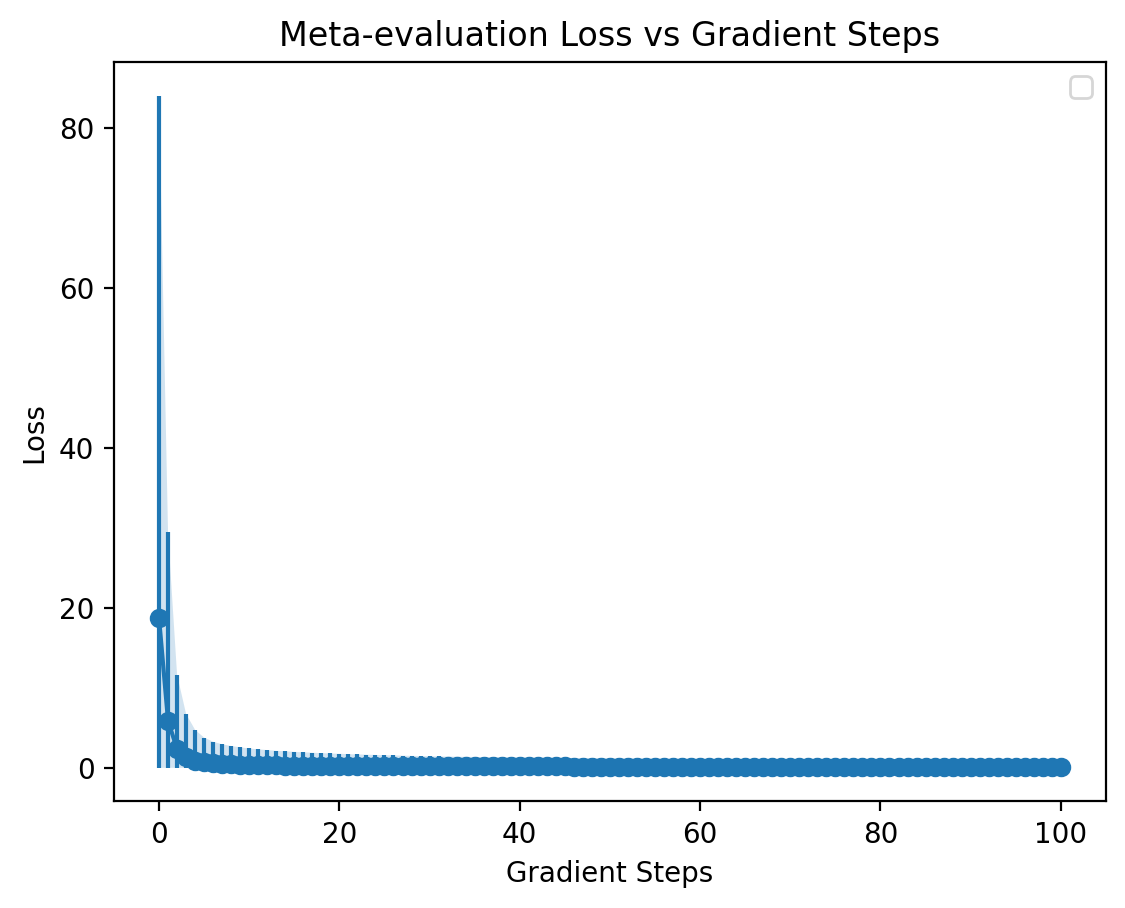

In [43]:
metaeval_mu = metaeval_losses.mean(axis=0)
assert metaeval_mu.shape == (test_numstep + 1,)
metaeval_ci = 1.96 * metaeval_losses.std(axis=0)

lower_err = np.minimum(metaeval_ci, metaeval_mu)  # ensures lower bound ≥ 0
upper_err = metaeval_ci
yerr = np.vstack([lower_err, upper_err])

x = np.arange(test_numstep + 1)
plt.errorbar(x, metaeval_mu, yerr=yerr, fmt='-o')
plt.fill_between(x, np.maximum(0, metaeval_mu - metaeval_ci), metaeval_mu + metaeval_ci, alpha=0.2)

plt.xlabel('Gradient Steps')
plt.ylabel('Loss')
plt.title('Meta-evaluation Loss vs Gradient Steps')
plt.legend()
plt.show()

In [ ]:
metaeval_mu

array([12.20298604,  4.46012643,  1.81981192,  1.00485433,  0.68570637,
        0.5291651 ,  0.43903973,  0.38128708,  0.34146282,  0.31295436,
        0.291798  ])

In [44]:
metaeval_mu

array([18.72395621,  5.89361244,  2.33837219,  1.31546888,  0.8942575 ,
        0.67852578,  0.55368744,  0.47468588,  0.42076551,  0.38151615,
        0.35152294,  0.32807829,  0.3091628 ,  0.29353229,  0.2802842 ,
        0.2690956 ,  0.25943594,  0.25094136,  0.24356545,  0.23688616,
        0.23106857,  0.22583194,  0.22100567,  0.2166011 ,  0.21252989,
        0.20880437,  0.2053852 ,  0.202123  ,  0.19917423,  0.19640205,
        0.19384855,  0.1913763 ,  0.18906667,  0.18696975,  0.18488292,
        0.18296345,  0.18115184,  0.17944952,  0.17785548,  0.17632125,
        0.17483625,  0.17342118,  0.17208345,  0.17077023,  0.16950791,
        0.16840763,  0.16720994,  0.1661327 ,  0.16514825,  0.16411577,
        0.16316809,  0.16228107,  0.16139741,  0.16056836,  0.15979672,
        0.15906195,  0.15830628,  0.15760707,  0.15691031,  0.15624548,
        0.15563609,  0.15504764,  0.15436476,  0.15370103,  0.15307946,
        0.15245865,  0.15182768,  0.15130941,  0.15070821,  0.15

In [28]:
metaeval_ci

array([49.25133841, 17.18896537,  6.39430475,  3.72258411,  2.57111584,
        1.92745894,  1.52483593,  1.25754418,  1.07131949,  0.93987666,
        0.84415729])

### Save/reload weights

In [11]:
torch.save(lpn.state_dict(), f'lpn_H{d_latent}_GA{numstep}_cmp.pth')

In [20]:
lpn = LPN(d_input=1,
          d_output=1,
          d_latent=d_latent,
          encoder=encoder,
          decoder=decoder).to(device)
state_dict = torch.load(f'lpn_H{d_latent}_GA{numstep}_cmp.pth')
lpn.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

### Micro-validation

In [ ]:
# one batch, 10 examples
test_xs, test_ys, amp, phase = SineDataGenerator(10, 1).generate()

amp = amp.item()
phase = phase.item()

test_xs.shape

torch.Size([1, 10, 1])

In [ ]:
io_pairs_t = torch.cat([test_xs, test_ys], dim=-1).to(device)  # (B, N, 2)
aux_t, loss_t = lpn(io_pairs_t, K=200, debug=True)

y_pred = aux_t["ys_pred"].detach().cpu().numpy()
z_mu = aux_t["z_mu"].detach()
z_logvar = aux_t["z_logvar"].detach()
z_sample = aux_t["z_sample"].detach()
z_prime = aux_t["z_prime"].detach()

torch.sum(mse).item()=34.09320068359375
torch.sum(mse).item()=27.195241928100586
torch.sum(mse).item()=21.85491180419922
torch.sum(mse).item()=17.852924346923828
torch.sum(mse).item()=14.834786415100098
torch.sum(mse).item()=12.549891471862793
torch.sum(mse).item()=10.878182411193848
torch.sum(mse).item()=9.618252754211426
torch.sum(mse).item()=8.669098854064941
torch.sum(mse).item()=7.9207844734191895
torch.sum(mse).item()=7.347499847412109
torch.sum(mse).item()=6.894000053405762
torch.sum(mse).item()=6.5231428146362305
torch.sum(mse).item()=6.210165977478027
torch.sum(mse).item()=5.937753677368164
torch.sum(mse).item()=5.694766044616699
torch.sum(mse).item()=5.475494861602783
torch.sum(mse).item()=5.2711710929870605
torch.sum(mse).item()=5.079256534576416
torch.sum(mse).item()=4.901695251464844
torch.sum(mse).item()=4.735004901885986
torch.sum(mse).item()=4.57808780670166
torch.sum(mse).item()=4.430240631103516
torch.sum(mse).item()=4.290562152862549
torch.sum(mse).item()=4.157602310

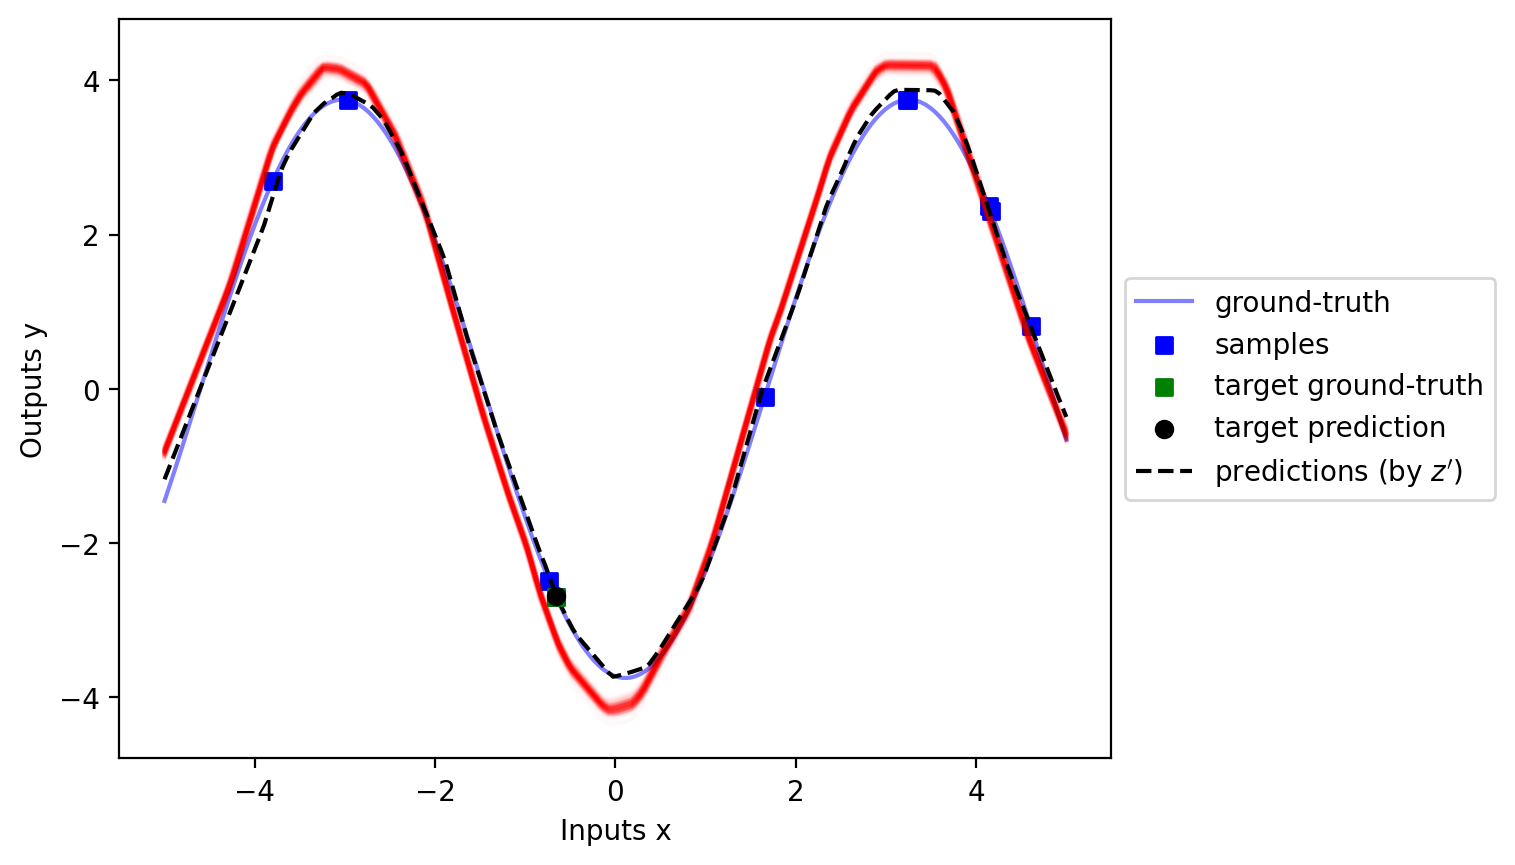

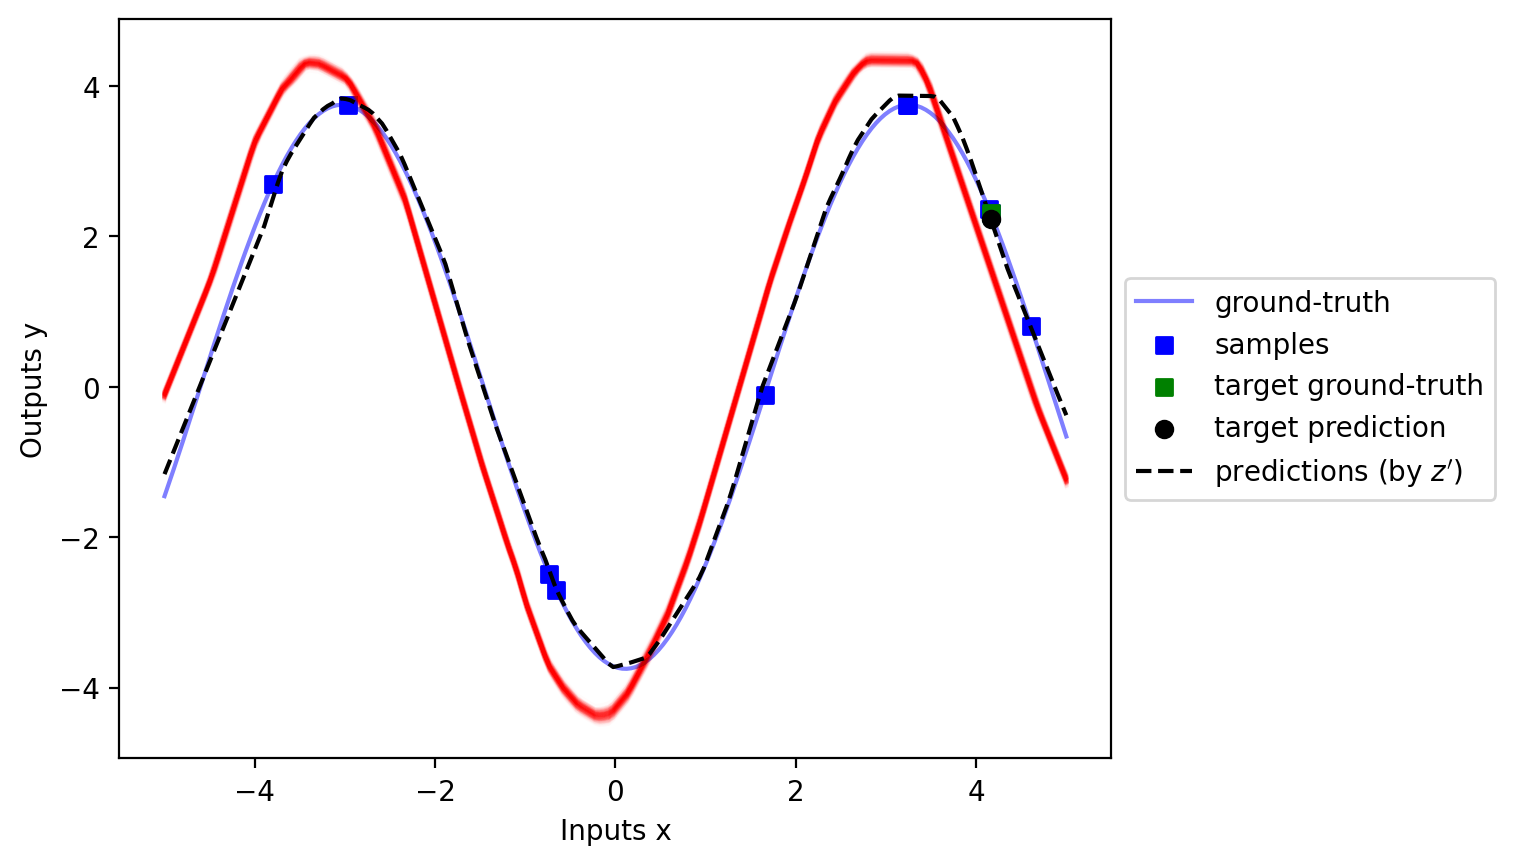

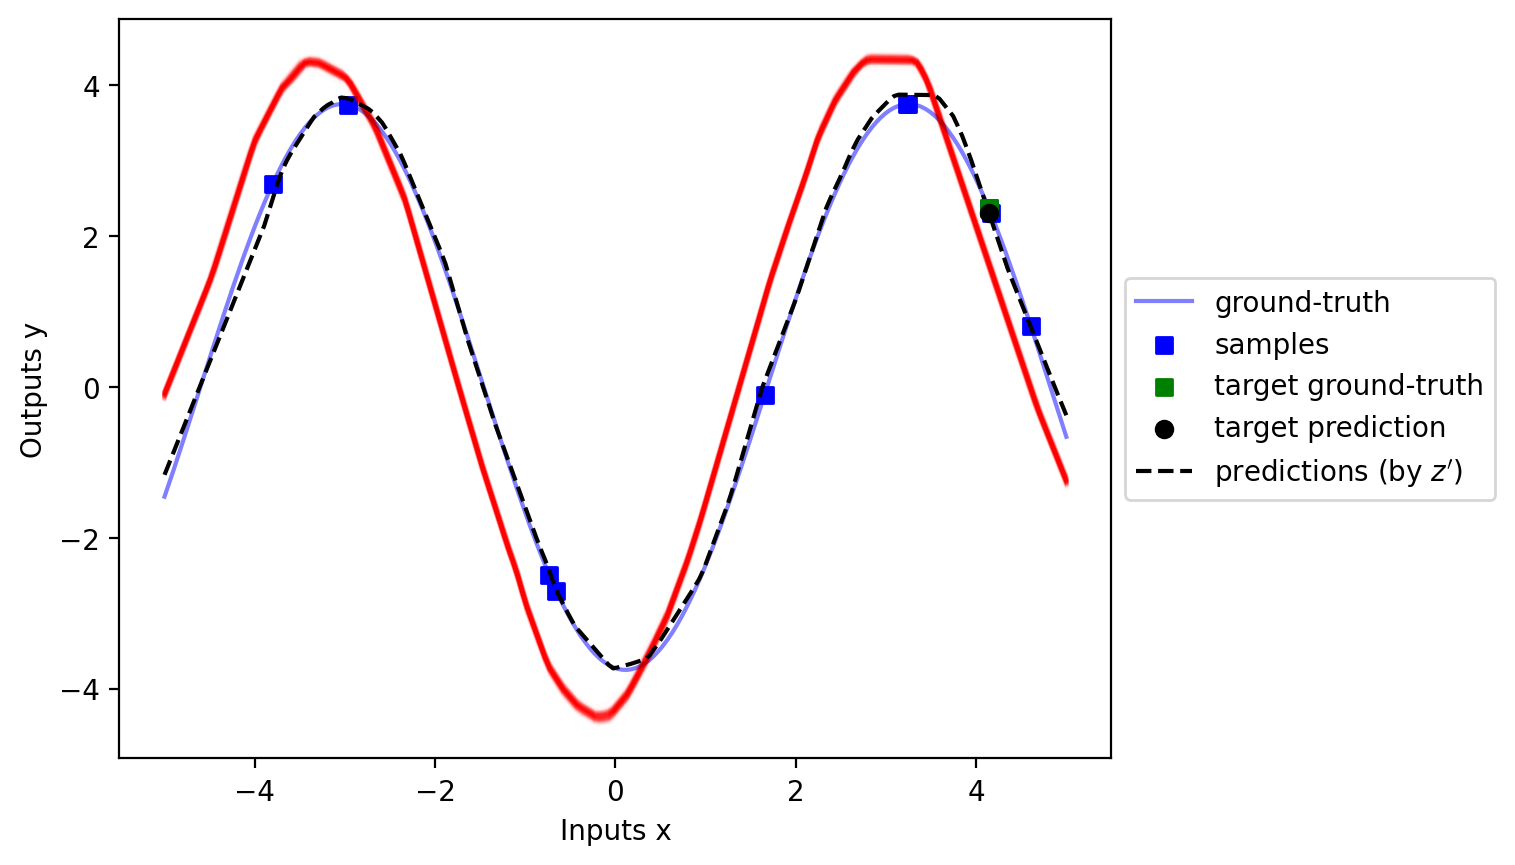

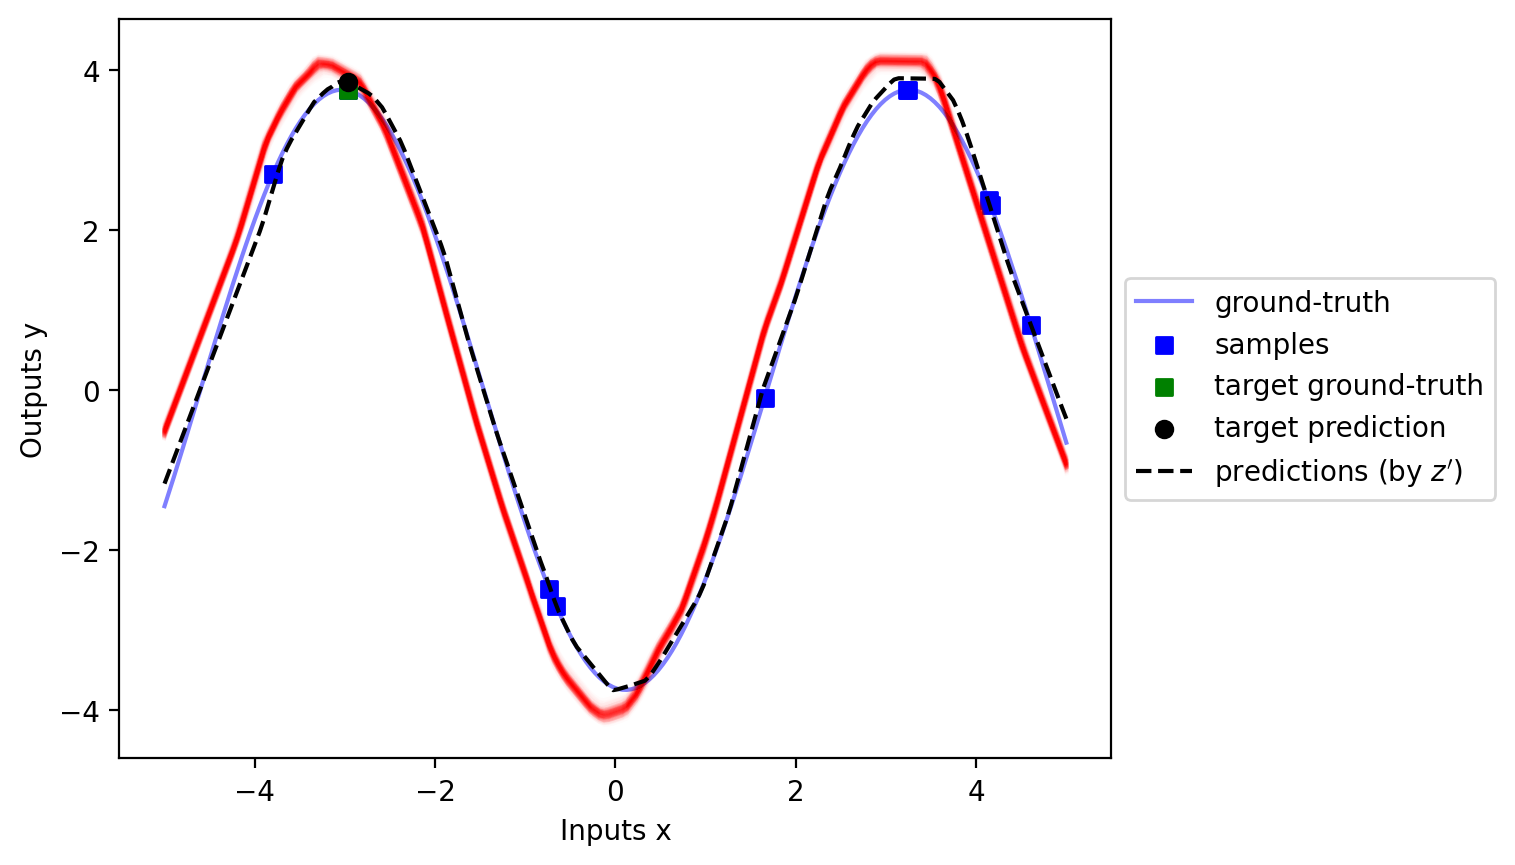

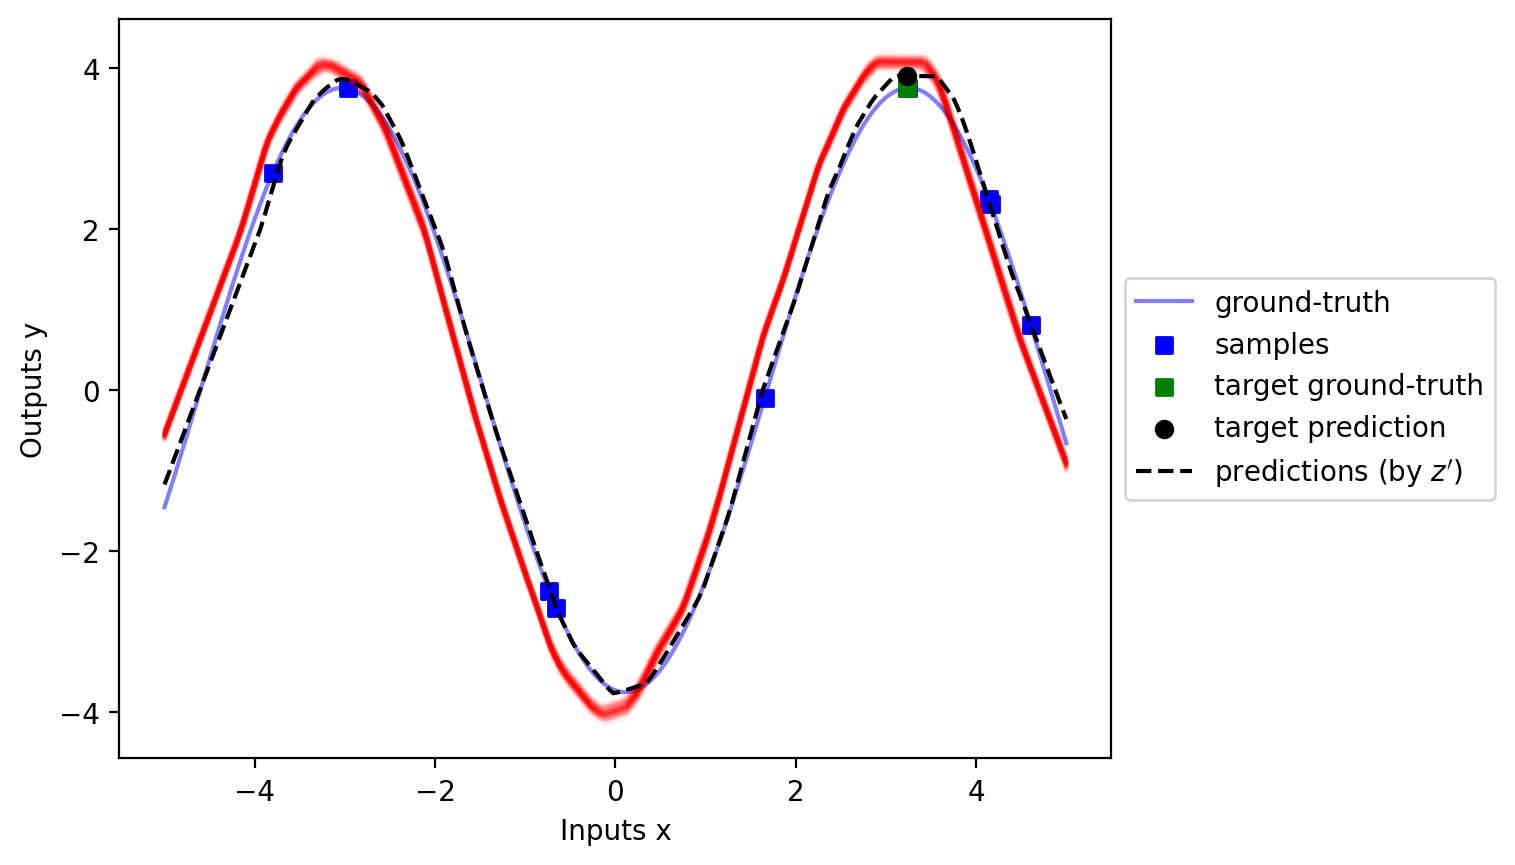

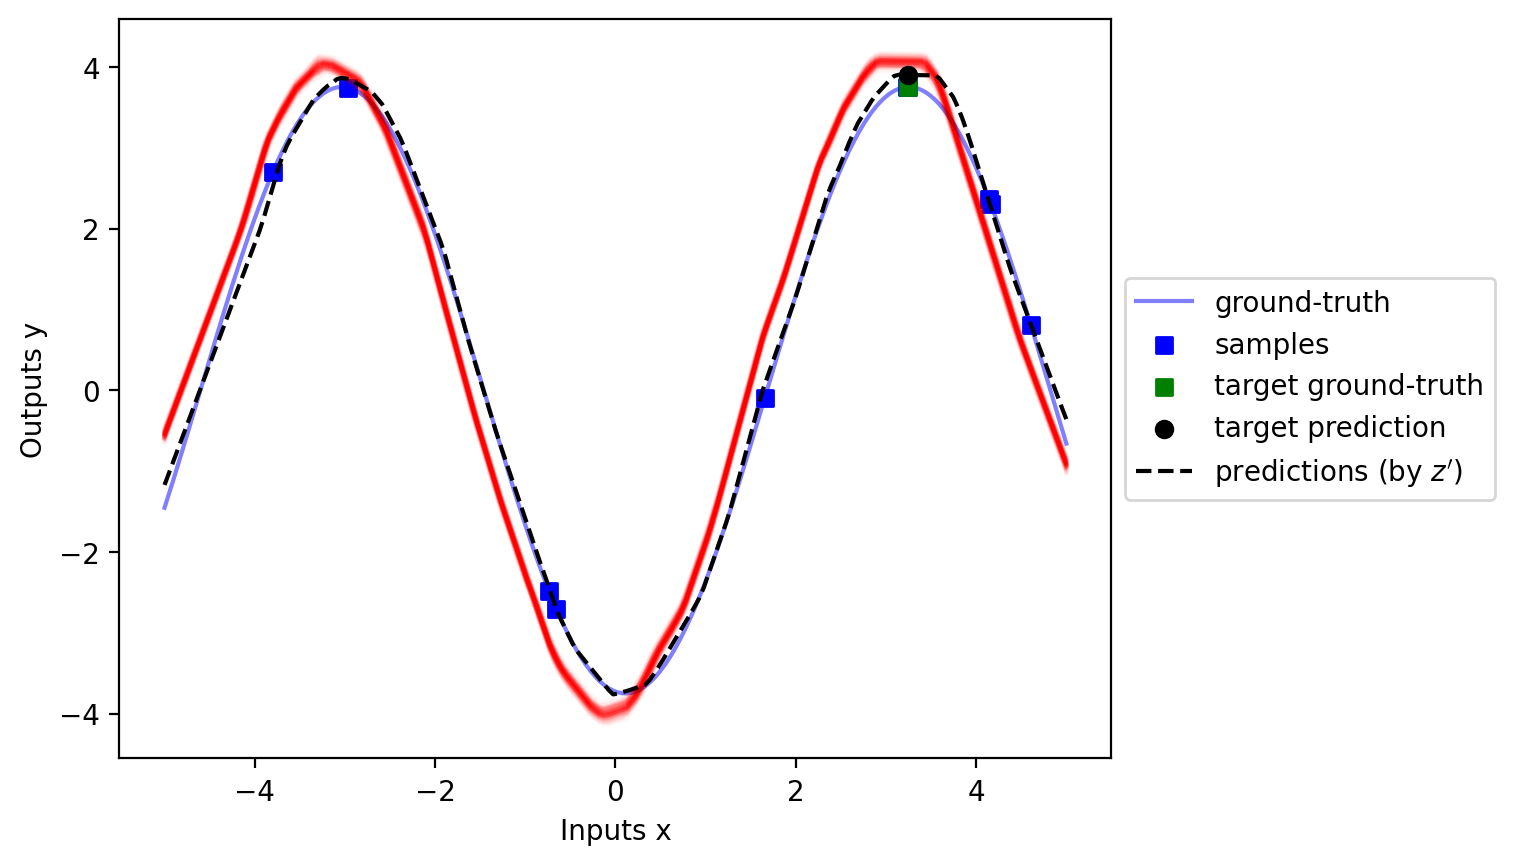

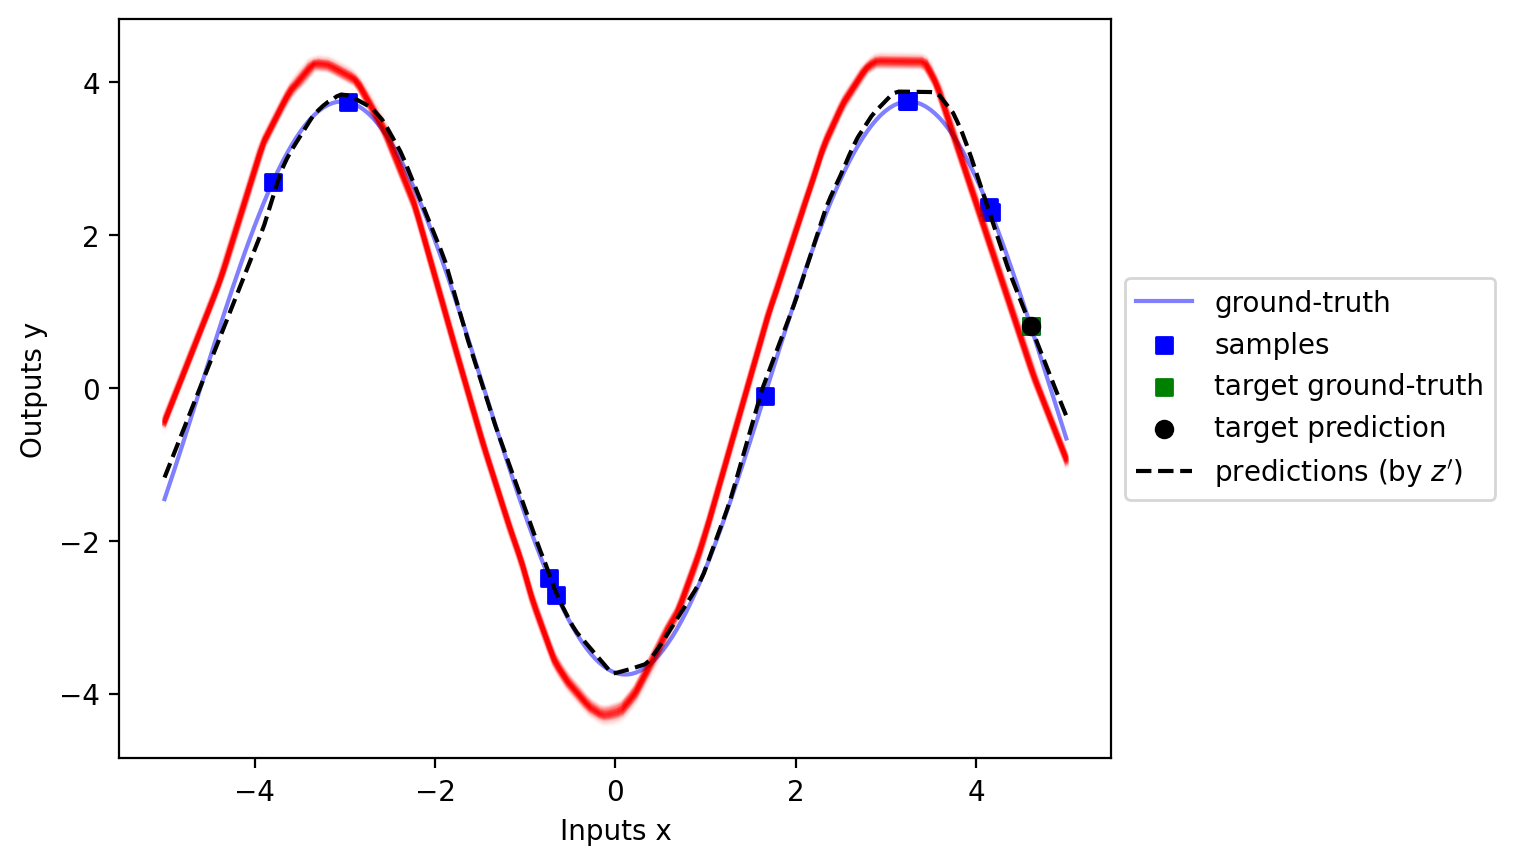

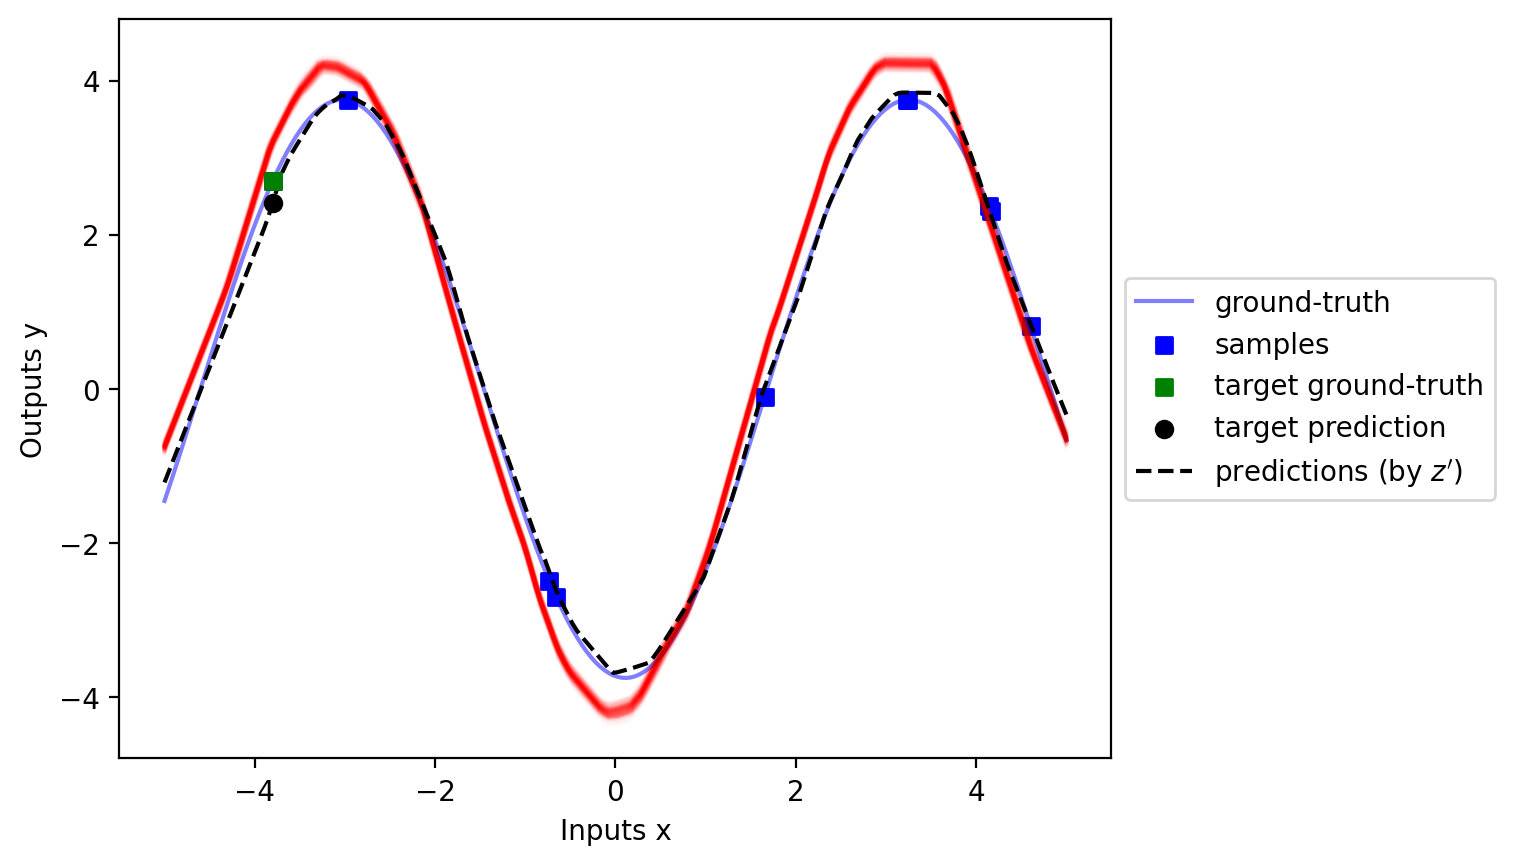

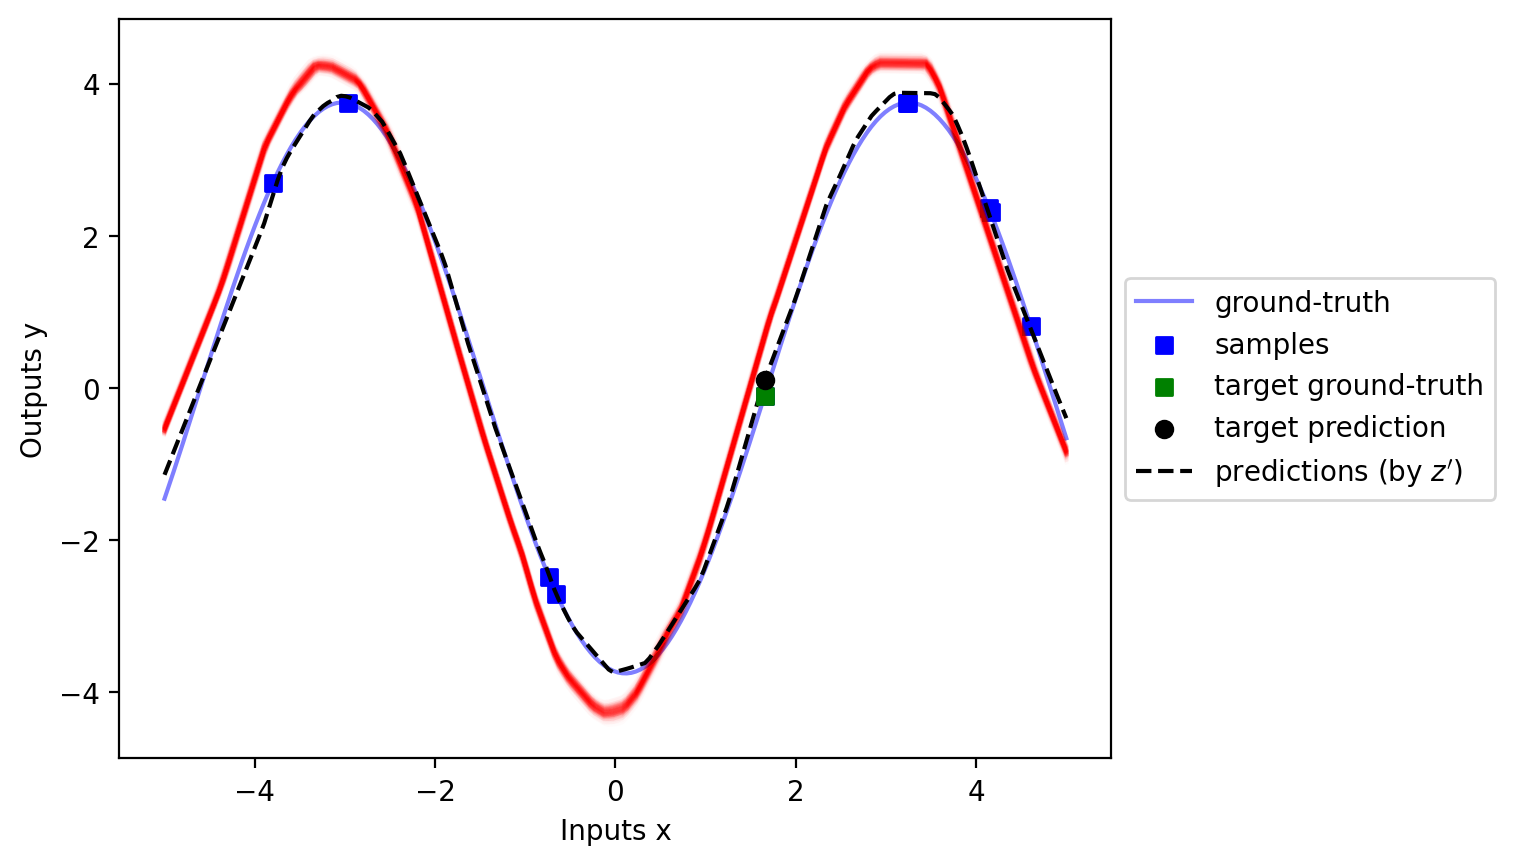

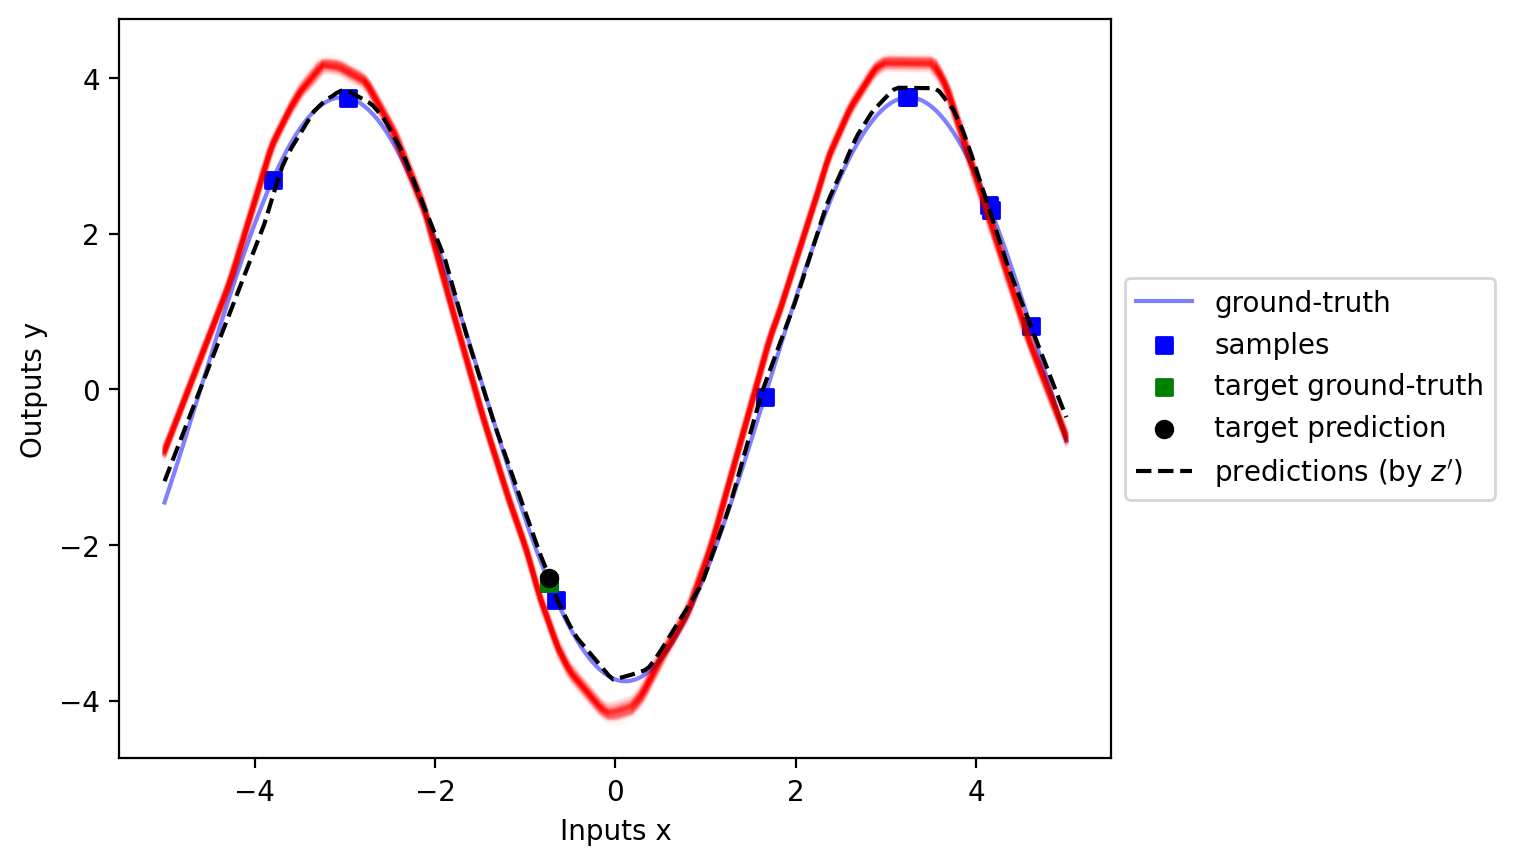

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 200)

for i in range(10):
    # Plot ground-truth
    y = amp * np.sin(x - phase)
    plt.plot(x, y, label=f"ground-truth", color='blue', alpha=.5, zorder=20)

    # Plot samples
    plt.scatter(test_xs, test_ys, label=f"samples", color='blue', marker='s', zorder=30)

    # Plot all predictions
    # plt.scatter(sample_xs, yhat, marker='o', color='blue', label=f"predictions")

    # Plot target x,y (sample i of batch 0), and its prediction
    x_i = test_xs[0, i].item()
    y_i = test_ys[0, i].item()
    yhat_i = y_pred[0, i].item()
    plt.scatter(x_i, y_i, marker='s', color='green', label=f"target ground-truth", zorder=60)
    plt.scatter(x_i, yhat_i, marker='o', color='k', label=f"target prediction", zorder=70)

    # Plot the predicted latent program (z_mu_i) conditioned on the 9 other samples
    z_mu_i = z_mu[0, i]
    z_pr_i = z_prime[0, i]
    x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (100, 1)
    y_pred_z_mu_i = lpn.decode(z_mu_i, x_prep).detach().cpu().numpy()
    y_pred_z_pr_i = lpn.decode(z_pr_i, x_prep).detach().cpu().numpy()
    # plt.plot(x, yhat_z_mu_i, label="predictions (by $z^{(i)}_\\mu$)",
    #          color='k', linestyle='dashed', alpha=1, zorder=50)
    plt.plot(x, y_pred_z_pr_i, label="predictions (by $z'$)",
             color='k', linestyle='dashed', alpha=1, zorder=50)

    # Plot some sampled latent programs
    n_samples = 200
    for j in range(n_samples):
        z_init = lpn.sample_latents(z_mu_i, z_logvar[0, i])
        y_pred_z = lpn.decode(z_init, x_prep).detach().cpu().numpy()
        # label = f"predictions (by $z \\sim N(\\mu_z, \\Sigma_z)$)"
        plt.plot(x, y_pred_z, color='red', alpha=3/n_samples, zorder=40)

    plt.xlabel("Inputs x")
    plt.ylabel("Outputs y")
    # plt.title("Outputs vs Inputs")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
test_xs[0, 0]

tensor([0.3108])

In [ ]:
x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (100, 1)
x_prep.shape

torch.Size([100, 1])

In [ ]:
z_sample[0, 0].shape

torch.Size([2])

### [WIP] Algorithm 1: Test-Time Inference

In [ ]:
# # Input
# inputs, outputs_pred, amp, phase = [torch.Tensor(arr) for arr in data_gen.generate()]
# # Context: n=10 input-output pairs (x_i, y_i)
# ctx_inputs = inputs[:, :-1, :]
# ctx_outputs = outputs_pred[:, :-1, :]
# # Test input x_{n+1}
# test_inputs = inputs[:, -1, :].unsqueeze(1)
# test_outputs = outputs_pred[:, -1, :].unsqueeze(1)
# number of gradient steps

### Plotting sample tasks

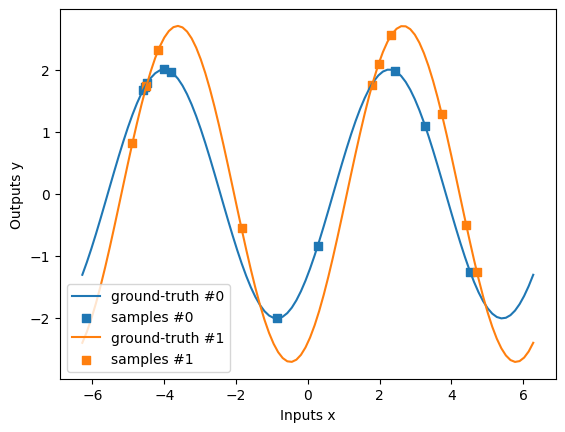

In [ ]:
import matplotlib.pyplot as plt

# Plot each set of inputs and outputs as a separate line
for i in range(min(2, inputs_np.shape[0])):
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    y = amp_np[i] * np.sin(x - phase_np[i])
    plt.plot(x, y, label=f"ground-truth #{i}")
    plt.scatter(inputs_np[i], outputs_np[i], marker='s', label=f"samples #{i}")
    # plt.plot(init_inputs[i], outputs[i], label=f"Line {i+1}")

plt.xlabel("Inputs x")
plt.ylabel("Outputs y")
# plt.title("Outputs vs Inputs")
plt.legend()
plt.show()